# Test the trained model with visualization

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from dataloaders import Dataset
from models.vit_mae.vit_translation import VitTranslation

### 1. Load saved model

In [3]:
def load_model(model, path_to_checkpoint):
    config_path = os.path.join(path_to_checkpoint, 'config.json')
    parameters_path = os.path.join(path_to_checkpoint, 'parameters.torch')
    with open(config_path) as f:
        config = json.load(f)
    model = model(**config["model"])
    checkpoint = torch.load(parameters_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

path_to_checkpoint = "/nfs/home/clruben/workspace/nst/models/vit_mae/checkpoints/vit_mae-08-09-2023-10_07_29"
model = load_model(VitTranslation, path_to_checkpoint)

device = torch.device("cuda:0")
model.to(device)

model.eval()
print("Done.")

Done.


### 2. Load test dataset

In [7]:
source = "/nfs/home/clruben/workspace/nst/data/"

ct = Dataset(source, "test", "CT")
mr = Dataset(source, "test", "MR")

### 3. Test the model on some images

In [33]:
def to_numpy(torch_variable):
    return torch_variable.detach().cpu().numpy()

input_batch_index = 0
input_batch = mr[input_batch_index]
input_type = "MR"

input_batch = torch.tensor(input_batch).to(device)
with torch.no_grad():
    outputs = model(input_batch, input_type)

pred = to_numpy(model.unpatchify(outputs.pred))
mask = to_numpy(outputs.mask)

In [34]:
input_image_index = 1
input_img = input_batch.cpu().numpy()[input_image_index][0]
pred_img = pred[input_image_index][0]
mask_reshaped = mask[input_image_index].reshape(32,32)
def apply_mask(img, mask):
    img_copy = img.copy()
    mask_size = img.shape[0]//mask.shape[0]
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] == 1:
                img_copy[i*mask_size:(i+1)*mask_size, j*mask_size:(j+1)*mask_size] = 0
    return img_copy
masked_img = apply_mask(input_img, mask_reshaped)

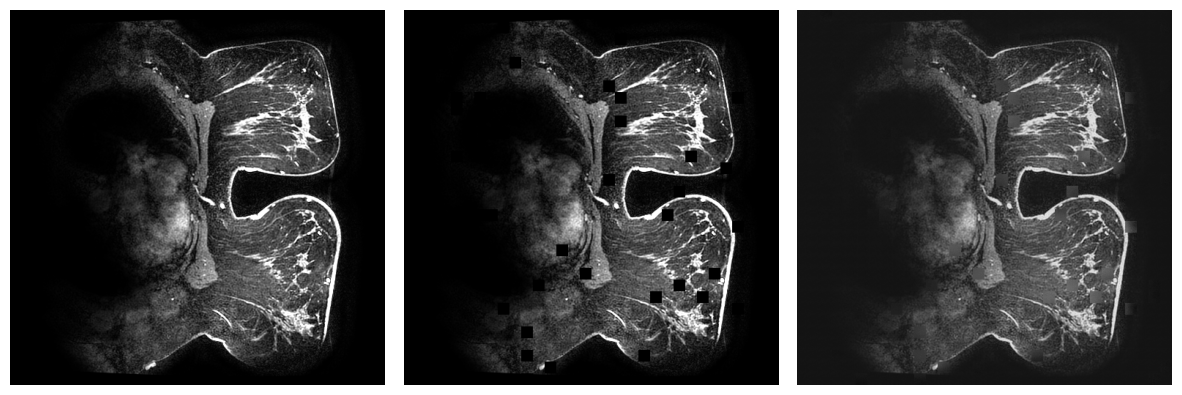

In [35]:
# show input_img, masked_img, and pred_img side by side with subplots
f, axarr = plt.subplots(1,3, figsize=(15, 15))

axarr[0].imshow(input_img, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(masked_img, cmap='gray')
axarr[1].axis('off')
axarr[2].imshow(pred_img, cmap='gray')
axarr[2].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0)


In [11]:
outputs.loss

tensor(0.0001, device='cuda:0')

In [12]:
print(np.min(pred_img), np.max(pred_img))

-0.026738996 0.5107166
